### To show that the new python version is in agreement with previous matlab version

Matlab version has the analytical solution without accounting for fluid inertia. The python version accounts for magma inertia, radiation damping, and has a solution that was non-dimensionalized slightly differently. This notebook has two purposes:
1. To make sure the new python implementation is correct
2. To see the effects of fluid ineria, radiation damping

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import calcol 
import matlab.engine
import time as Ti
import os

# load all the necessary parameters
directory = os.getcwd()
parameters = np.loadtxt(directory+'/inversion_input/parameters.txt', delimiter=',', usecols= 1)

pi = np.pi

R = 1000    # piston radius   [m]
rho_p = 2500 # piston density  [kg/m^3]
V_c = 4e9    # chamber volume  [m^3]
L = 885.5451      # piston length   [m]

A = pi*R**2 # cross sectional area of piston [m^2]

sigma_n = 10e6
fs = 0.875
fd = 0.806

beta = 7.98e-10          # total reservoir compressibility           [Pa^-1]
eff_rho_m = 0    # effective density of magma = phi*rho_m    [kg/m^3]
g = 9.8                 # gravitational constant                    [m/s^2]
dtau = sigma_n*(fs-fd)# change in shear stress                    [Pa] should 

u_i = 0
v_i = 0
p_i = (np.pi*R**2*L*rho_p*g-2*np.pi*R*L*fs*sigma_n)/(np.pi*R**2)

consts = np.array([rho_p, eff_rho_m, L, g, R, beta, dtau, V_c])



In [6]:
# Test out python version
T, Ut, Pt, St, DeltaT, DeltaU, DeltaP, DeltaS = calcol.calcol_alyt(consts, plot='NO')

consts2 = np.array([rho_p, eff_rho_m, L, g, R, beta, dtau, V_c])
T1, Ut1, Pt1, St1, DeltaT1, DeltaU1, DeltaP1, DeltaS1 = calcol.calcol_alyt(consts2, plot='NO')

# Test out matlab version
eng = matlab.engine.start_matlab()
eng.addpath("/Users/taiyiwang/Desktop/VLP/source_code/")

consts2 = [eng.double(rho_p), eng.double(L), eng.double(g), eng.double(R), eng.double(beta), eng.double(sigma_n), eng.double(V_c), eng.double(fs), eng.double(fd)];
init2 = [eng.double(u_i), eng.double(v_i), eng.double(p_i)]

consts2 = eng.cell2mat(eng.cell(consts2))
init2 = eng.cell2mat(eng.cell(init2))
consts2 = consts2[0]
init2 = init2[0]
    
eng.clear
[time, displacement, pressure, shear_stress] = eng.calcol_alyt(consts2, init2, 0, 0, nargout=4)

time = np.array(time[0])
displacement = np.array(displacement[0])
pressure= np.array(pressure[0])
shear_stress = np.array(shear_stress[0])

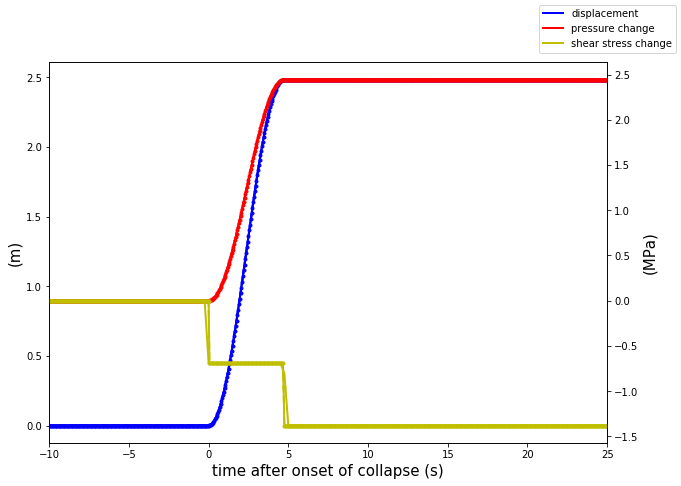

In [7]:
# Plot matlab and python results on the same plot
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()
ax1.plot(time, displacement, 'b-', linewidth=2, label = 'displacement')
ax1.plot(T, Ut, 'b--',linewidth=2)
ax1.plot(T, Ut1, 'b.-',linewidth=2)
ax1.set_xlabel('time after onset of collapse (s)', fontsize=15)
ax1.set_ylabel('(m)', fontsize=15)
ax2.plot(time, (pressure-p_i)/1e6, 'r-', linewidth=2,label = 'pressure change')
ax2.plot(T, Pt/1e6, 'r--',linewidth=2)
ax2.plot(T, Pt1/1e6, 'r.-',linewidth=2)
ax2.plot(time, (shear_stress-sigma_n*fs)/1e6, 'y-', linewidth=2, label = 'shear stress change')
ax2.plot(T, St/1e6, 'y--', linewidth=2)
ax2.plot(T, St1/1e6, 'y.-', linewidth=2)
ax2.set_ylabel('(MPa)', fontsize=15)
plt.xlim([-10,25])
fig.legend()


### Check that the single force has zero impulse

Text(0, 0.5, 'force (N)')

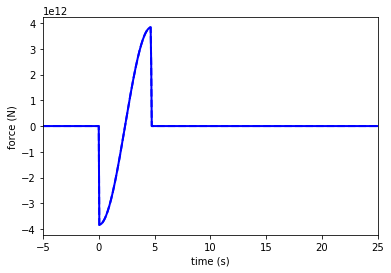

In [8]:
f = Pt*A + St*2*pi*R*L
f1 = Pt1*A + St1*2*pi*R*L

plt.figure()
plt.plot(T, f, 'b-', linewidth=2)
plt.plot(T1, f1, 'b--', linewidth=2)
plt.xlim([-5, 25])
plt.xlabel('time (s)')
plt.ylabel('force (N)')